# Inference on custom data

In [ ]:
from fastMONAI.vision_all import *
from huggingface_hub import snapshot_download
from scipy.ndimage import label

In [ ]:
# Download the models from the study repository and load exported learners 
models_path = Path(snapshot_download(repo_id="skaliy/endometrical_cancer_segmentation",  cache_dir='models'))

In [ ]:
DATA_DIR = Path('../data/ec_project')

In [ ]:
learner = load_learner(models_path/'learner.pkl', cpu=True)

In [ ]:
# Load variables
vars_fn = models_path/'vars.pkl'
_, reorder, resample = load_variables(pkl_fn=vars_fn)
reorder, resample

(False, [1, 1, 1])

In [ ]:
def find_similar_size_labels(labeled_mask, size_threshold=0.8):
    """
    Find labels of components in a labeled mask that are of similar size 
    to the largest component.
    """
    
    sizes = np.bincount(labeled_mask.ravel())
    max_label = sizes[1:].argmax() + 1
    threshold_size = size_threshold * sizes[max_label]
    similar_size_labels = [
        label for label, size in enumerate(sizes[1:], start=1)
        if size >= threshold_size
    ]

    return max_label, similar_size_labels

In [ ]:
# Define your path
img_path = DATA_DIR/'img_246.nii.gz'
save_path = str(img_path).replace(img_path.stem, 'pred_' +img_path.stem)
#save_path = img_path.with_stem('pred_' + img_path.stem) python 3.9 <=

In [ ]:
#pred_items
org_img, input_img, org_size = med_img_reader(img_path, reorder=reorder, resample=resample, only_tensor=False)

    #Predict with ensemble
mask_data = inference(learner, reorder=reorder, resample=resample, org_img=org_img, input_img=input_img, org_size=org_size).data 
labeled_mask, ncomponents = label(mask_data.numpy())
if ncomponents > 1: 
    max_label, similar_size_labels = find_similar_size_labels(labeled_mask)
    if len(similar_size_labels) == 1:
        mask_data = torch.Tensor(np.where(labeled_mask == max_label, 1, 0))
    else: 
        print(save_path)

if "".join(org_img.orientation) == 'LSA':        
    mask_data = mask_data.permute(0,1,3,2)
    mask_data = torch.flip(mask_data[0], dims=[1])
    mask_data = torch.Tensor(mask_data)[None]
    
org_img.set_data(mask_data)
org_img.save(save_path)

../data/ec_project/pred_img_246.nii.gz


In [ ]:
from torchio import Subject, ScalarImage, LabelMap

In [ ]:
subject = Subject(image=ScalarImage(img_path), mask=LabelMap(save_path))

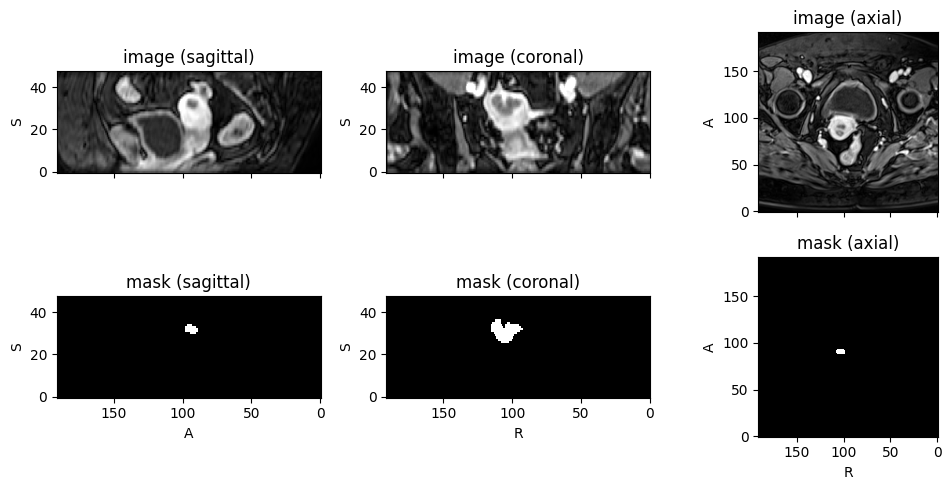

In [ ]:
subject.plot(figsize=(10,5))